In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1);

## Read data

In [3]:
import os
seq_len = 64
im_size = 28

In [4]:
def read_img_sequences(path_to_folder, size=200):
    curr_size = 0
    data = []
    labels = []
    
    for sequence_folder in os.listdir(path_to_folder):
        curr_size += 1
        full_sequence_folder = os.path.join(path_to_folder, sequence_folder)
        sequence_img = [None] * seq_len
        sequence_labels = [None] * seq_len
        
        for img_path in os.listdir(full_sequence_folder):
            # -3: drop .pt
            im_index, label = img_path[:-3].split('_')
            im_index = int(im_index)
            label = int(label)

            full_path_to_img = os.path.join(full_sequence_folder, img_path)
            # load image and reshape to vector
            img = torch.load(full_path_to_img).view(-1, im_size * im_size).detach().cpu().numpy()
            sequence_img[im_index] = img
            sequence_labels[im_index] = label
        data.append(sequence_img)
        labels.append(sequence_labels)
        if curr_size ==  size:
            break
    return data, labels

In [5]:
anomaly_data, anomaly_labels = read_img_sequences('img_ts_anomaly/')
normal_data, normal_labels = read_img_sequences('img_ts_normal/')

In [6]:
all_data = np.vstack((anomaly_data, normal_data))
all_labels = np.vstack((anomaly_labels, normal_labels))

all_labels = (all_labels == 7).astype(int)

In [163]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, 
                                                                    test_size=0.4, shuffle=True,
                                                                    random_state=42)

test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, 
                                                                test_size=0.5, shuffle=True,
                                                                random_state=42)

In [32]:
train_labels.shape

(240, 64)

## Loss function

In [203]:
def loss_delay_detection_2(p_slice):
    n = p_slice.size(0)
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    prod[1:] -= p_slice[:-1]
    cumprod = torch.cumprod(prod, dim=0).to(device)
    loss = torch.arange(1, n + 1).to(device) * p_slice * cumprod
    loss = torch.sum(loss)
    return loss


def loss_delay_detection(p_slice, w):
    n = p_slice.size(0) 
    prod = torch.ones(n).to(device)
    p_slice = p_slice.to(device)
    
    prod[1:] -= p_slice[:-1].to(device)
    cumprod = torch.cumprod(prod, dim=0).to(device)
    # TODO drop either n or w
    loss = (torch.arange(1, n + 1).to(device) * p_slice * cumprod 
            + (w + 1) * torch.prod(prod[1:]) * (1 - p_slice[-1]))
    loss = torch.sum(loss)
    return loss

def loss_false_alarms(p_slice):
    length = len(p_slice)
    loss = 0
    
    start_ind = 0
    end_ind = 0
    
    while end_ind < length:
        start_ind = end_ind - 1
        if start_ind < 0:
            start_ind = 0
        end_ind = np.random.randint(start_ind, length + 2)
        if end_ind == start_ind:
            end_ind = end_ind + 1
        loss += 1 - loss_delay_detection_2(p_slice[start_ind: end_ind + 1])    
    #loss += 1 - loss_delay_detection_2(p_slice[start_ind: length])            
    loss = torch.sum(loss)
    return loss

In [204]:
loss_delay_detection(torch.Tensor([0.9, 0.1, 0.3]), 3)

tensor(1.7570, device='cuda:1')

In [205]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        
    def forward(self, outputs, labels):
        loss = torch.zeros(labels.size(0))
        for i, label in enumerate(labels):
            ind = torch.where(label != label[0])[0]
            if ind.size()[0] == 0:
                loss[i] = loss_false_alarms(outputs[i, :])
            else:
                w = 16
                alpha = 0.5
                loss[i] = (alpha * loss_delay_detection(outputs[i, ind[0]:(ind[0] + w)], w) + 
                           (1 - alpha) * loss_false_alarms(outputs[i, :ind[0]]))
        loss = torch.mean(loss)
        return loss


## Model

In [33]:
# input data parameters
input_size = im_size * im_size
output_size = seq_len

# model hyperparameters
hidden_dim = 100
n_layers = 2
num_workers = 1
learning_rate = 1e-3

batch_size = 64

In [34]:
def prepare_loader(data, labels, seq_len, input_size, batch_size, shuffle=True, num_workers=1):
    data = torch.FloatTensor(data)
    labels = torch.FloatTensor(labels)
    data = data.view(-1, seq_len, input_size)
    labels = labels.view(-1, seq_len)
    
    all_data = TensorDataset(data, labels) 
    data_loader = DataLoader(all_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return data_loader

In [35]:
train_loader = prepare_loader(train_data, train_labels, seq_len, input_size, batch_size)
val_loader = prepare_loader(val_data, val_labels, seq_len, input_size, batch_size)
test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

In [36]:
device = torch.device("cuda:1")

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        # if batch_first, than shape of lstm_in: [batch_size, seq_len, input_size]
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.linear_1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear_2 = nn.Linear(hidden_dim//2, 1)
        self.activation = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, input_seq, hidden):
        batch_size = input_seq.size(0)
        lstm_out, hidden = self.lstm(input_seq, hidden)  
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)      
        out = self.linear_1(lstm_out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear_2(out)
        out = self.activation(out)
        out = out.view(batch_size, -1)

        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [38]:
def train_model(model, loss_function, epochs=100, print_every=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
    valid_loss_min = np.Inf

    loss_list = []
    acc_list = []
    overall_val_loss_list = []
    counter = 0
    model.train()

    out_list = []
    labels_list = []

    model.train()
    for i in range(epochs):
        # for inputs, labels in tqdm(train_loader):
        for inputs, labels in train_loader:
            if inputs.shape[0] < batch_size:
                break

            counter += 1
            h = model.init_hidden(batch_size)
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)  

            # shape of lstm_in: [seq_len, batch_size, input_size]
            # shape of lstm_out: [input_size, batch_size, hidden_dim]
            # shape of self.hidden: (a, b), where a and b both 
            # have shape (num_layers, batch_size, hidden_dim).

            output, h = model(inputs, h)
            loss = loss_function(output.squeeze(), labels.float())
            loss_list += [loss.cpu().clone().detach()]
            accuracy = (output > 0.5).long() == labels
            acc_list += [accuracy.cpu().detach().float().mean()]
            out_list.append(output.cpu().detach().float())
            labels_list.append(labels.cpu().detach().float())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if counter%print_every == 0:
                val_losses = []
                val_outputs = []
                model.eval()
                for val_inputs, val_labels in val_loader:
                    if val_inputs.shape[0] < batch_size:
                        break
                    val_h = model.init_hidden(batch_size)
                    val_h = tuple([each.data for each in val_h])
                    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                    val_out, val_h = model(val_inputs, val_h)
                    val_loss = loss_function(val_out.squeeze(), val_labels.float())
                    val_losses.append(val_loss.item())
                    val_outputs += [val_out.cpu().clone().detach()]

                val_outputs_one = torch.cat(val_outputs, 0)

                overall_val_loss_list.append(np.mean(val_losses))

                model.train()
                print("Epoch: {}/{}...".format(i+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
    return model, (loss_list, acc_list, overall_val_loss_list)

In [47]:
model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
loss_function = CustomLoss()
# loss_function = torch.nn.BCELoss()
model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [48]:
model, (loss_list, acc_list, overall_val_loss_list) = train_model(model, loss_function, 60, 5)

Epoch: 2/60... Step: 5... Loss: -2.396424... Val Loss: -2.584548
Epoch: 4/60... Step: 10... Loss: -2.543310... Val Loss: -3.127618
Epoch: 5/60... Step: 15... Loss: -2.308076... Val Loss: -4.537995
Epoch: 7/60... Step: 20... Loss: -4.938120... Val Loss: -5.065134
Epoch: 9/60... Step: 25... Loss: -6.390418... Val Loss: -7.277781
Epoch: 10/60... Step: 30... Loss: -9.907799... Val Loss: -8.962917
Epoch: 12/60... Step: 35... Loss: -9.430336... Val Loss: -11.661111
Epoch: 14/60... Step: 40... Loss: -11.866062... Val Loss: -10.041057
Epoch: 15/60... Step: 45... Loss: -10.453949... Val Loss: -14.019263
Epoch: 17/60... Step: 50... Loss: -12.297573... Val Loss: -14.178621
Epoch: 19/60... Step: 55... Loss: -12.729675... Val Loss: -12.841836
Epoch: 20/60... Step: 60... Loss: -13.741068... Val Loss: -15.385564
Epoch: 22/60... Step: 65... Loss: -12.366045... Val Loss: -15.036719
Epoch: 24/60... Step: 70... Loss: -14.070938... Val Loss: -16.166916
Epoch: 25/60... Step: 75... Loss: -13.162624... Val L

In [53]:
bce_model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
bce_loss_function = torch.nn.BCELoss()
bce_model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [54]:
bce_model, (bce_loss_list, bce_acc_list, bce_overall_val_loss_list) = train_model(bce_model, bce_loss_function, 60, 5)

Epoch: 2/60... Step: 5... Loss: 0.652956... Val Loss: 0.622841
Epoch: 4/60... Step: 10... Loss: 0.471227... Val Loss: 0.393638
Epoch: 5/60... Step: 15... Loss: 0.320831... Val Loss: 0.220280
Epoch: 7/60... Step: 20... Loss: 0.191861... Val Loss: 0.174226
Epoch: 9/60... Step: 25... Loss: 0.132564... Val Loss: 0.101028
Epoch: 10/60... Step: 30... Loss: 0.079675... Val Loss: 0.066174
Epoch: 12/60... Step: 35... Loss: 0.046874... Val Loss: 0.042519
Epoch: 14/60... Step: 40... Loss: 0.041746... Val Loss: 0.039837
Epoch: 15/60... Step: 45... Loss: 0.032789... Val Loss: 0.040676
Epoch: 17/60... Step: 50... Loss: 0.030591... Val Loss: 0.038674
Epoch: 19/60... Step: 55... Loss: 0.026620... Val Loss: 0.034395
Epoch: 20/60... Step: 60... Loss: 0.021998... Val Loss: 0.031478
Epoch: 22/60... Step: 65... Loss: 0.022087... Val Loss: 0.020304
Epoch: 24/60... Step: 70... Loss: 0.017969... Val Loss: 0.041681
Epoch: 25/60... Step: 75... Loss: 0.023682... Val Loss: 0.024528
Epoch: 27/60... Step: 80... Los

In [141]:
combined_model = LSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
first_bce_loss_function = torch.nn.BCELoss()
second_custom_loss_function = CustomLoss()
combined_model.to(device)

LSTM(
  (lstm): LSTM(784, 100, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=100, out_features=50, bias=True)
  (linear_2): Linear(in_features=50, out_features=1, bias=True)
  (activation): Sigmoid()
  (relu): ReLU()
)

In [142]:
combined_model, _ = train_model(combined_model, second_custom_loss_function, 30, 5)

Epoch: 2/30... Step: 5... Loss: -2.375360... Val Loss: -2.293823
Epoch: 4/30... Step: 10... Loss: -2.538542... Val Loss: -3.584368
Epoch: 5/30... Step: 15... Loss: -3.095886... Val Loss: -3.903049
Epoch: 7/30... Step: 20... Loss: -5.752299... Val Loss: -5.860615
Epoch: 9/30... Step: 25... Loss: -5.596341... Val Loss: -7.847956
Epoch: 10/30... Step: 30... Loss: -7.347698... Val Loss: -8.557808
Epoch: 12/30... Step: 35... Loss: -8.510746... Val Loss: -12.668288
Epoch: 14/30... Step: 40... Loss: -9.456797... Val Loss: -14.281020
Epoch: 15/30... Step: 45... Loss: -9.948517... Val Loss: -13.591798
Epoch: 17/30... Step: 50... Loss: -12.678982... Val Loss: -12.835143
Epoch: 19/30... Step: 55... Loss: -12.735806... Val Loss: -11.479342
Epoch: 20/30... Step: 60... Loss: -12.410119... Val Loss: -15.136717
Epoch: 22/30... Step: 65... Loss: -13.289753... Val Loss: -11.812472
Epoch: 24/30... Step: 70... Loss: -13.606292... Val Loss: -15.187730
Epoch: 25/30... Step: 75... Loss: -13.433582... Val Los

In [143]:
combined_model, __ = train_model(combined_model, first_bce_loss_function, 30, 5)

Epoch: 2/30... Step: 5... Loss: 0.086336... Val Loss: 0.069749
Epoch: 4/30... Step: 10... Loss: 0.038315... Val Loss: 0.046827
Epoch: 5/30... Step: 15... Loss: 0.028164... Val Loss: 0.034819
Epoch: 7/30... Step: 20... Loss: 0.042677... Val Loss: 0.033432
Epoch: 9/30... Step: 25... Loss: 0.027373... Val Loss: 0.024678
Epoch: 10/30... Step: 30... Loss: 0.026638... Val Loss: 0.029103
Epoch: 12/30... Step: 35... Loss: 0.027199... Val Loss: 0.023431
Epoch: 14/30... Step: 40... Loss: 0.020121... Val Loss: 0.027434
Epoch: 15/30... Step: 45... Loss: 0.018427... Val Loss: 0.028474
Epoch: 17/30... Step: 50... Loss: 0.020130... Val Loss: 0.026742
Epoch: 19/30... Step: 55... Loss: 0.023819... Val Loss: 0.020771
Epoch: 20/30... Step: 60... Loss: 0.022643... Val Loss: 0.027246
Epoch: 22/30... Step: 65... Loss: 0.016077... Val Loss: 0.024814
Epoch: 24/30... Step: 70... Loss: 0.018108... Val Loss: 0.023084
Epoch: 25/30... Step: 75... Loss: 0.013071... Val Loss: 0.024026
Epoch: 27/30... Step: 80... Los

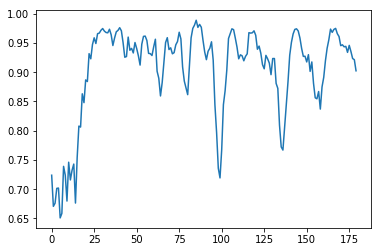

In [49]:
plt.plot(acc_list[::]);

(0.95, 1)

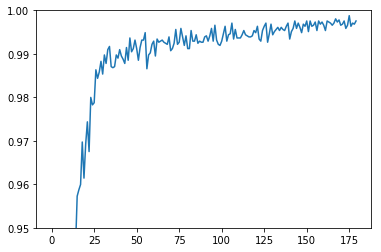

In [56]:
plt.plot(bce_acc_list[::]);
plt.ylim([0.95, 1])

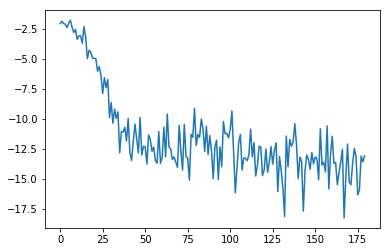

In [50]:
plt.plot(loss_list[::]);

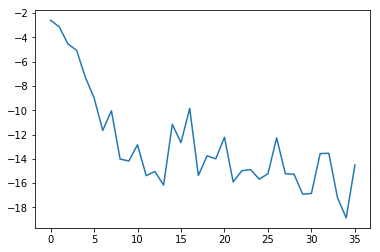

In [51]:
plt.plot(overall_val_loss_list);

## Plots for model output

In [161]:
test_loss_list = []
test_acc_list = []

model.eval()
bce_model.eval()
for test_inputs, test_labels in test_loader:

    if test_inputs.shape[0] < batch_size:
        break
    test_hidden = model.init_hidden(batch_size)
    test_hidden = tuple([each.data for each in test_hidden])

    test_inputs, test_true_labels = test_inputs.to(device), test_labels.to(device)
    test_predictions, test_hidden = model(test_inputs, test_hidden)
    test_predictions_bce, test_hidden = bce_model(test_inputs, test_hidden)
    
model.train()
bce_model.train();

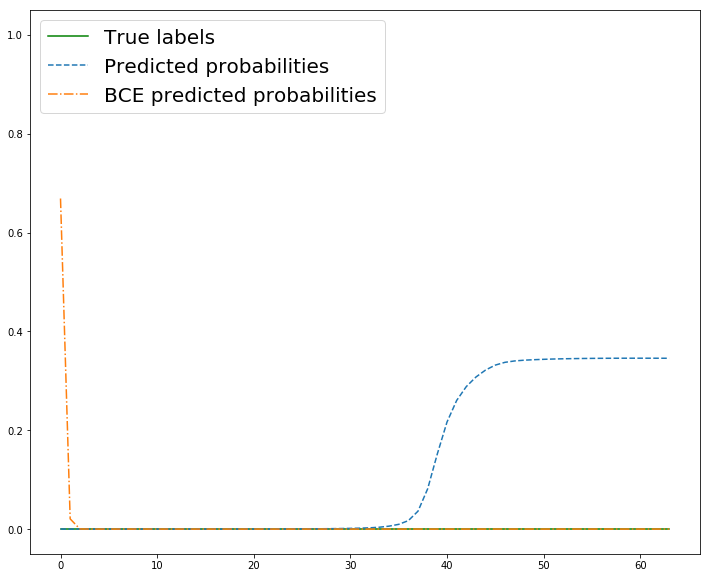

In [162]:
index = 15
plt.figure(figsize=(12, 10))
plt.plot(test_true_labels[index].cpu().detach().numpy(), color='green', label='True labels')
plt.plot(test_predictions[index].cpu().detach().numpy(), '--', label='Predicted probabilities')
plt.plot(test_predictions_bce[index].cpu().detach().numpy(), '-.', label='BCE predicted probabilities')
plt.legend(loc='upper left', fontsize=20);
plt.ylim([-.05, 1.05]);

## Calculate metrics for different models

In [233]:
def evaluate_metrics(y_true, y_pred, threshold=0.5):
    """
    Evaluate metrics for change point detection
    We assume, that there is no more than one change index in data (so, either 0 or 1 change)
    Inputs
    y_true : torch.Tensor
      true labels
    y_pred : torch.Tensor
      change probabiltiy
    threshold : float
      detection threshold
      
    Returns
    false_positive : int
      number of false positives
    false_negative : int
      number of false positives
    delay : int
      detection delay
    accuracy : float
      y_pred accuracy given y_true
    """
    delay = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    index_real = torch.where(y_true != y_true[0])[0] # indexes with real changes
    index_detected = torch.where((y_pred > threshold).long() != y_true[0])[0] # indexes with predicted changes

    if len(index_real) > 0:
        real_change_index = index_real[0]

        if len(index_detected) > 0:
            index_sub_detected = torch.where(index_detected >= real_change_index)[0]

            if len(index_sub_detected) == len(index_detected):
                false_positive_delay = real_change_index.item()
                detected_change_index = index_detected[0]
                delay = (detected_change_index - real_change_index).item()
            else:
                false_positive_delay = index_detected[0].item()
                delay = 0
                false_positive += 1
                
        else:
            false_positive_delay = seq_len
            delay = (seq_len - real_change_index).item()
            false_negative += 1

    else:
        if len(index_detected) > 0:
            false_positive_delay = index_detected[0].item()
            false_positive += 1
        else:
            false_positive_delay = seq_len
            true_negative += 1
    
    accuracy = ((y_pred > threshold).long() == y_true).float().mean().item()
    
    return false_positive, false_negative, delay, false_positive_delay, accuracy

In [234]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

In [235]:
def get_quality_metrics(test_loader, model, threshold=0.5):
    test_loss_list = []
    test_acc_list = []

    positive_number = 0 
    negative_number = 0
    fp_list = []
    fn_list = []
    delay_list = []
    fp_delay_list = []
    accuracy_list = []

    model.eval()
    for test_inputs, test_true_labels in test_loader:

        if test_inputs.shape[0] < test_batch_size:
            break
        test_hidden = model.init_hidden(batch_size)
        test_hidden = tuple([each.data for each in test_hidden])

        test_inputs, test_true_labels = test_inputs.to(device), test_true_labels.to(device)
        test_predictions, test_hidden = model(test_inputs, test_hidden)
        test_loss = loss_function(test_predictions.squeeze(), test_true_labels.float())
        test_loss_list += [test_loss.cpu().clone().detach()]

        for i in range(0, test_batch_size):
            curr_labels = test_true_labels[i]
            curr_predictions = test_predictions[i]
            
            # torch.rand_like
            curr_fp, curr_fn, curr_delay, curr_fp_delay, curr_accuracy = evaluate_metrics(curr_labels, curr_predictions, 
                                                                           threshold)

            max_difference = np.abs((curr_labels.max() - curr_labels.min()).item())
            if max_difference: 
                delay_list.append(curr_delay)
            positive_number += (max_difference > 0)
            negative_number += 1 - (max_difference > 0)

            fp_list.append(curr_fp)
            fn_list.append(curr_fn)
            fp_delay_list.append(curr_fp_delay)
            accuracy_list.append(curr_accuracy)

        test_acc_list.append(np.mean(accuracy_list[-test_batch_size:]))
        
    return (positive_number, negative_number, np.mean(test_loss_list), np.mean(test_acc_list), np.mean(delay_list),
            np.mean(fp_delay_list), np.sum(fp_list), np.sum(fn_list))

In [236]:
(positive_number, negative_number, test_loss, 
test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, 0.1)
    
print("Positive number: ", positive_number)
print("Negative number: ", negative_number)
print("Test loss: {:.3f}".format(test_loss))
print("Test accuracy: {:.3f}".format(test_acc))
print("Test delay: {:.2f}".format(mean_delay))
print("Test FP delay: {:.2f}".format(mean_fp_delay))
print("Test FP: ", fp_number)
print("Test FN: ", fn_number)

# custom loss metrics:
# Test loss: -18.444
# Test accuracy: 0.850%
# Test delay: 0.05
# Test FP:  93
# Test FN:  0

Positive number:  40
Negative number:  24
Test loss: -12.171
Test accuracy: 0.755
Test delay: 0.10
Test FP delay: 21.41
Test FP:  55
Test FN:  0


In [237]:
def get_pareto_metrics_for_threshold(model, test_loader, threshold_list):
    fp_number_list = []
    fn_number_list = []
    delay_list = []
    fp_delay_list = []
    for threshold in threshold_list:
        # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)

        (positive_number, negative_number, test_loss, 
         test_acc, mean_delay, mean_fp_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)

        fp_number_list.append(fp_number)
        fn_number_list.append(fn_number)
        delay_list.append(mean_delay)
        fp_delay_list.append(mean_fp_delay)
        print(threshold, fp_number, fn_number, mean_delay, mean_fp_delay)
    
    return fp_number_list, fn_number_list, delay_list, fp_delay_list

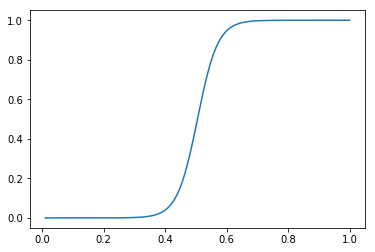

In [283]:
threshold_number = 200
threshold_list = np.linspace(-15, 15, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
plt.plot(np.linspace(0.01, 1, threshold_number), threshold_list)

In [284]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

In [285]:
(fp_number_list, fn_number_list, 
 delay_list, fp_delay_list) = get_pareto_metrics_for_threshold(model, final_test_loader, threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.9999946353732554 0 38 40.44736842105263 64.0
0.99999538609863 0 42 41.30952380952381 64.0
0.9999960317679817 0 39 42.38461538461539 64.0
0.9999965870826732 0 42 40.57142857142857 64.0
0.9999970646868129 0 42 42.04761904761905 64.0
0.9999974754551293 0 43 41.48837209302326 64.0
0.9999978287405701 0 43 41.7906976744186 64.0
0.99999813258725 0 41 41.48780487804878 64.0
0.999998393913605 0 38 42.473684210526315 64.0
0.9999986186699144 0 41 41.4390243902439 64.0
0.9999988119737823 0 40 40.875 64.0
0.9999989782266594 0 41 42.292682926829265 64.0
0.9999991212140611 0 43 41.27906976744186 64.0
0.9999992441917592 0 39 40.94871794871795 64.0
0.9999993499599145 0 43 41.55813953488372 64.0
0.9999994409268332 0 41 39.170731707317074 64.0
0.9999995191638043 0 43 41.97674418604651 64.0
0.99999958645226 0 41 40.951219512195124 64.0
0.9999996443243392 0 40 41.65 64.0
0.999999694097773 0 41 40.073170731707314 64.0


In [286]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

(fp_number_list_combined, fn_number_list_combined, 
 delay_list_combined, fp_delay_list_combined) = get_pareto_metrics_for_threshold(combined_model, final_test_loader, 
                                                                                             threshold_list)

3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.9999937624985265 0 39 42.1025641025641 64.0
0.9999946353732554 0 44 41.38636363636363 64.0
0.99999538609863 0 43 41.627906976744185 64.0
0.9999960317679817 0 40 40.225 64.0
0.9999965870826732 0 43 42.74418604651163 64.0
0.9999970646868129 0 39 42.64102564102564 64.0
0.9999974754551293 0 40 40.85 64.0
0.9999978287405701 0 44 41.0 64.0
0.99999813258725 0 42 42.57142857142857 64.0
0.999998393913605 0 43 41.81395348837209 64.0
0.9999986186699144 0 40 40.825 64.0
0.9999988119737823 0 45 41.06666666666667 64.0
0.9999989782266594 0 42 41.69047619047619 64.0
0.9999991212140611 0 42 41.5 64.0
0.9999992441917592 0 41 41.78048780487805 64.0
0.9999993499599145 0 41 40.58536585365854 64.0
0.9999994409268332 0 42 41.214285714285715 64.0
0.9999995191638043 0 39 41.1025641025641 64.0
0.99999958645226 0 40 41.525 64.0
0.9999996443243392 0 37 41.432432432432435 64.0
0.999999694097773 0 42 40.976190476190474 64.0


In [287]:
test_batch_size = 64
final_test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, test_batch_size)

(fp_number_list_bce, fn_number_list_bce, 
 delay_list_bce, fp_delay_list_bce) = get_pareto_metrics_for_threshold(bce_model, final_test_loader, 
                                                                       threshold_list)



3.059022269256247e-07 64 0 0.0 0.0
3.5567566069455447e-07 64 0 0.0 0.0
4.135477399343811e-07 64 0 0.0 0.0
4.808361957083632e-07 64 0 0.0 0.0
5.590731667609661e-07 64 0 0.0 0.0
6.500400855903908e-07 64 0 0.0 0.0
7.558082407498619e-07 64 0 0.0 0.0
8.787859389250973e-07 64 0 0.0 0.0
1.0217733405942518e-06 64 0 0.0 0.0
1.1880262177800208e-06 64 0 0.0 0.0
1.3813300855273949e-06 64 0 0.0 0.0
1.6060863949070788e-06 64 0 0.0 0.0
1.8674127499275664e-06 64 0 0.0 0.0
2.171259429985438e-06 64 0 0.0 0.0
2.5245448706559623e-06 64 0 0.0 0.0
2.935313187166708e-06 64 0 0.0 0.0
3.4129173266193407e-06 64 0 0.0 0.0
3.968232018336215e-06 64 0 0.0 0.0
4.613901369867859e-06 64 0 0.0 0.0
5.3646267446155565e-06 64 0 0.0 0.0
6.2375014736103725e-06 64 0 0.0 0.0
7.2524000195603246e-06 64 0 0.0 0.0
8.43243045001736e-06 64 0 0.0 0.0
9.804460516527986e-06 64 0 0.0 0.0
1.1399729310565373e-05 64 0 0.0 0.0
1.3254558412823157e-05 64 0 0.0 0.0
1.5411178714132362e-05 64 0 0.0 0.0
1.7918691714996185e-05 64 0 0.0 0.0
2.0834

0.999998393913605 0 44 42.54545454545455 64.0
0.9999986186699144 0 39 40.48717948717949 64.0
0.9999988119737823 0 41 41.048780487804876 64.0
0.9999989782266594 0 39 41.17948717948718 64.0
0.9999991212140611 0 40 42.75 64.0
0.9999992441917592 0 39 41.17948717948718 64.0
0.9999993499599145 0 40 42.4 64.0
0.9999994409268332 0 40 42.875 64.0
0.9999995191638043 0 43 40.86046511627907 64.0
0.99999958645226 0 41 40.390243902439025 64.0
0.9999996443243392 0 41 41.75609756097561 64.0
0.999999694097773 0 41 40.19512195121951 64.0


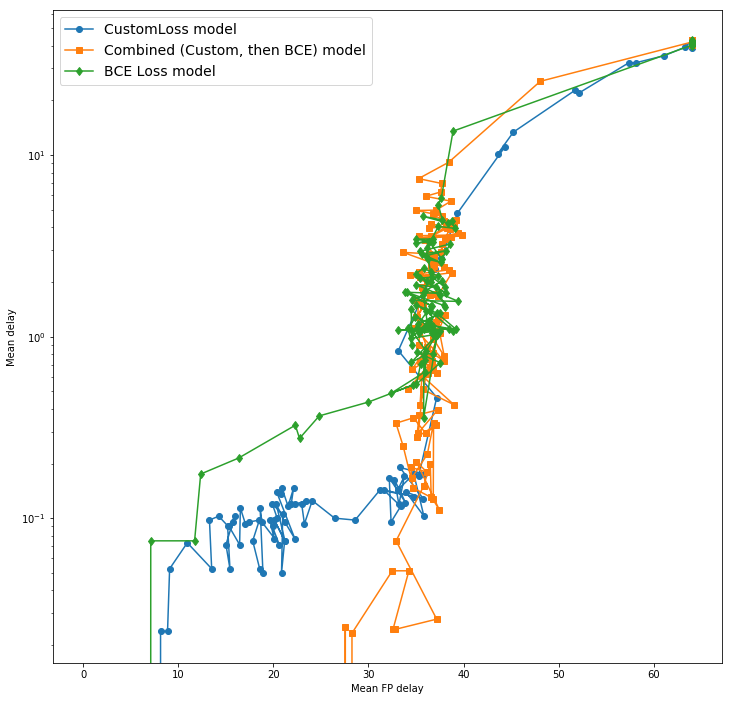

In [292]:
plt.figure(figsize=(12, 12))
plt.plot(fp_delay_list, delay_list, '-o', label='CustomLoss model')
plt.plot(fp_delay_list_combined, delay_list_combined, '-s', label='Combined (Custom, then BCE) model')
plt.plot(fp_delay_list_bce, delay_list_bce, '-d', label='BCE Loss model')
# plt.ylim([0, 25])
# plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
plt.xlabel('Mean FP delay')
plt.ylabel('Mean delay')
plt.yscale('log')
# plt.xlim([32, 40])
plt.legend(loc='upper left', fontsize=14);

In [173]:
# threshold_number = 50
# fp_number_list_random = []
# fn_number_list_random = []
# for threshold in np.linspace(0.9, 1, threshold_number):
#     print(threshold)
#     # test_loader = prepare_loader(test_data, test_labels, seq_len, input_size, batch_size)
    
#     (positive_number, negative_number, test_loss, 
#      test_acc, mean_delay, fp_number, fn_number) = get_quality_metrics(test_loader, model, threshold)
    
#     fp_number_list_random.append(fp_number)
#     fn_number_list_random.append(fn_number)

In [174]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, fn_number_list, 'o', label='CustomLoss model')
# plt.plot(fp_number_list_bce, fn_number_list_bce, 'd', label='BCE Loss model')
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('FN')
# plt.legend(loc='upper right', fontsize=20)

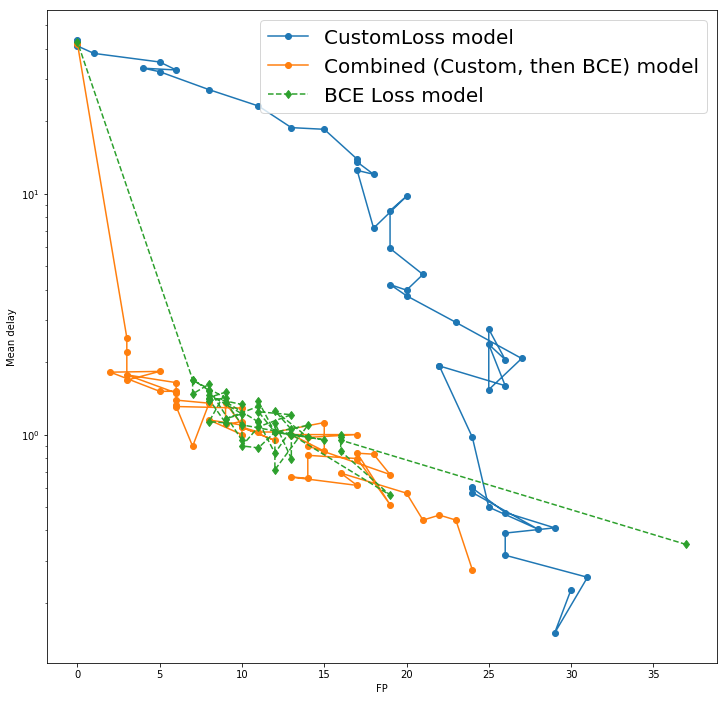

In [223]:
# plt.figure(figsize=(12, 12))
# plt.plot(fp_number_list, delay_list, '-o', label='CustomLoss model')
# plt.plot(fp_number_list_combined, delay_list_combined, '-o', label='Combined (Custom, then BCE) model')
# plt.plot(fp_number_list_bce, delay_list_bce, '--d', label='BCE Loss model')
# # plt.ylim([0, 25])
# # plt.plot(fp_number_list_random, fn_number_list_random, '--s', label='Random model')
# plt.xlabel('FP')
# plt.ylabel('Mean delay')
# plt.yscale('log')
# plt.legend(loc='upper right', fontsize=20);